<a href="https://colab.research.google.com/github/Bira0/GroupB/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Introduction***

*This project focuses on customer segmentation for a retail mall using unsupervised machine learning techniques. The dataset, sourced from a marketing case study, includes basic demographic and behavioral data collected through customer membership cards—such as Customer ID, age, gender, annual income, and a spending score assigned based on purchasing behavior. The objective is to identify distinct customer groups using various clustering methods, helping to inform targeted marketing strategies by recognizing high-value or easily convertible customer segments.*

#Getting the Data

Sourced from [Kaggle](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)

In [1]:
import kagglehub

path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/customer-segmentation-tutorial-in-python


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

csv_path = os.path.join(path, "Mall_Customers.csv")
data = pd.read_csv(csv_path)

data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


#Exploration

Dataset General Information

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


See if NULL values exist

In [5]:
data.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


Splitting the data, dropping 'CustomerID', as it does not carry any predictive information for clustering

In [6]:
X = data.drop('CustomerID', axis=1)

In [7]:
X['Gender'] = X['Gender'].map({'Female': 0, 'Male': 1})

In [8]:
X['Gender'].head(5)

,Gender
0,1
1,1
2,0
3,0
4,0


<ipython-input-9-22082121b2a2>:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(X['Gender'], bins=2, palette='pastel', discrete=True)


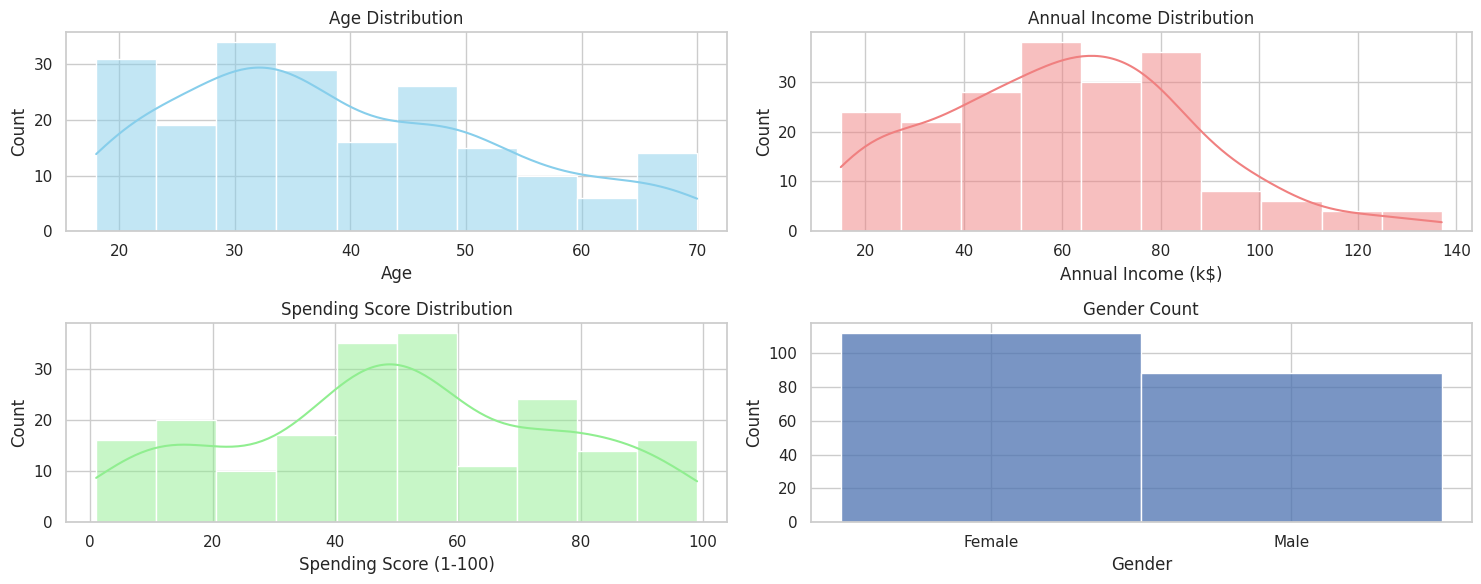

In [9]:
sns.set(style='whitegrid')
plt.figure(figsize=(15, 6))

plt.subplot(2, 2, 1)
sns.histplot(X['Age'], kde=True, bins=10, color='skyblue')
plt.title('Age Distribution')

plt.subplot(2, 2, 2)
sns.histplot(X['Annual Income (k$)'], kde=True, bins=10, color='lightcoral')
plt.title('Annual Income Distribution')

plt.subplot(2, 2, 3)
sns.histplot(X['Spending Score (1-100)'], kde=True, bins=10, color='lightgreen')
plt.title('Spending Score Distribution')

plt.subplot(2, 2, 4)
sns.histplot(X['Gender'], bins=2, palette='pastel', discrete=True)
plt.xticks([0, 1], ['Female', 'Male'])
plt.title('Gender Count')

plt.tight_layout()
plt.show()

<Axes: >

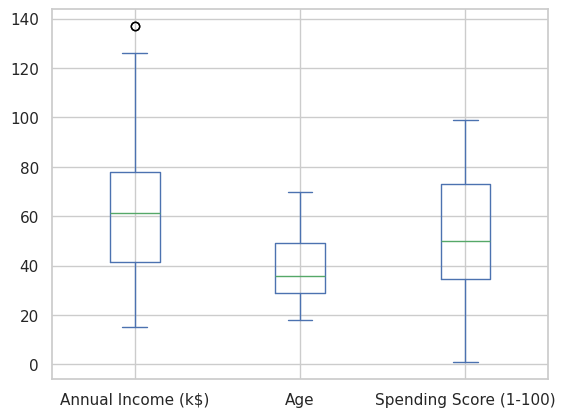

In [10]:
X[['Annual Income (k$)', 'Age' ,'Spending Score (1-100)']].plot(kind='box')

Lack of outliers, we'll standardize Age, Annual Income, Spending Score

#Preprocessing

**Feature Engineering**

**IncomeGroup or Category**

Since the lowest Annual income is 14 and highest is 137, we'll start the binning from 14 and end it at 140.

In [11]:
X['IncomeGroup'] = pd.cut(X['Annual Income (k$)'], bins=[14, 40, 70, 100, 140], labels=['Low', 'Medium', 'High', 'Very High'])

In [12]:
X['IncomeGroup']

,IncomeGroup
0,Low
1,Low
2,Low
3,Low
4,Low
...,...
195,Very High
196,Very High
197,Very High
198,Very High


In [13]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder(categories=[['Low', 'Medium', 'High', 'Very High']])
X['IncomeGroup'] = oe.fit_transform(X[['IncomeGroup']])
X['IncomeGroup']

,IncomeGroup
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
195,3.0
196,3.0
197,3.0
198,3.0


In [14]:
X['IncomeGroup'].unique()

array([0., 1., 2., 3.])

Since 'Gender' got already normalized by encoding to binary, we're not standardizing it. Same goes for 'IncomeGroup'

In [15]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] = ss.fit_transform(X[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])

<Axes: >

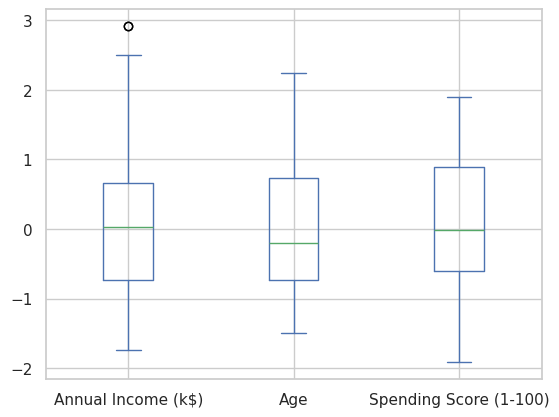

In [16]:
X[['Annual Income (k$)', 'Age' ,'Spending Score (1-100)']].plot(kind='box')

##PCA

Apply **PCA** to determine the minimum number of components preserving 90–95% variance

In [17]:
from sklearn.decomposition import PCA

pca = PCA().fit(X)
sum_variance = np.cumsum(pca.explained_variance_ratio_)

count = 0
for i in sum_variance:
  if i <= 0.95:
    count += 1

print(count)

3


In [18]:
sum_variance

array([0.43214912, 0.76096451, 0.9274815 , 0.98781438, 1.        ])

In [19]:
X.shape

(200, 5)

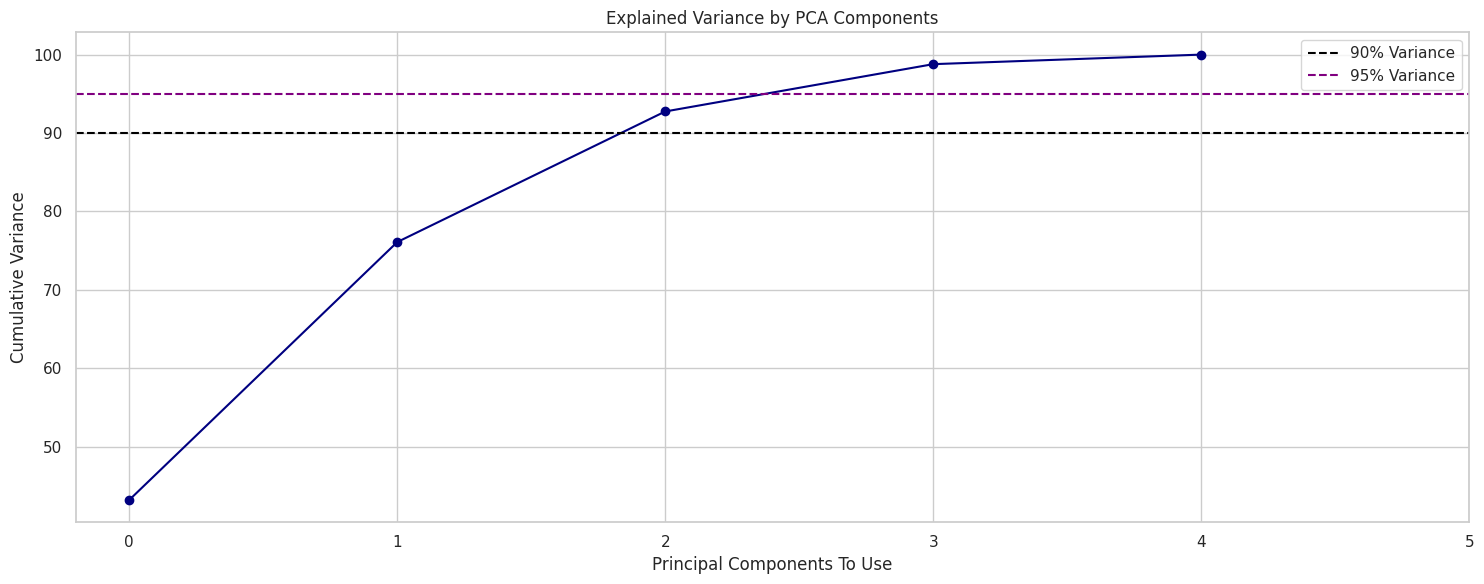

In [20]:
plt.figure(figsize=(15, 6))
plt.plot((sum_variance)*100, marker='o', color='navy')
plt.axhline(y=90, color='black', linestyle='--', label='90% Variance')
plt.axhline(y=95, color='purple', linestyle='--', label='95% Variance')
plt.xlabel('Principal Components To Use')
plt.ylabel('Cumulative Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.legend()
plt.xticks(np.arange(6))
plt.tight_layout()
plt.show()


Based on this plot, we can see that using two principal components allows us to explain approximately 92% of the total variance in the data, while this figure increases to around 98% with three principal components

---

Applying 'Count' or the sweet spot of number of components using PCA on the dataset

In [21]:
pcaCount = PCA(n_components=count)
X_pca = pcaCount.fit_transform(X)

X_pca.shape

(200, 3)

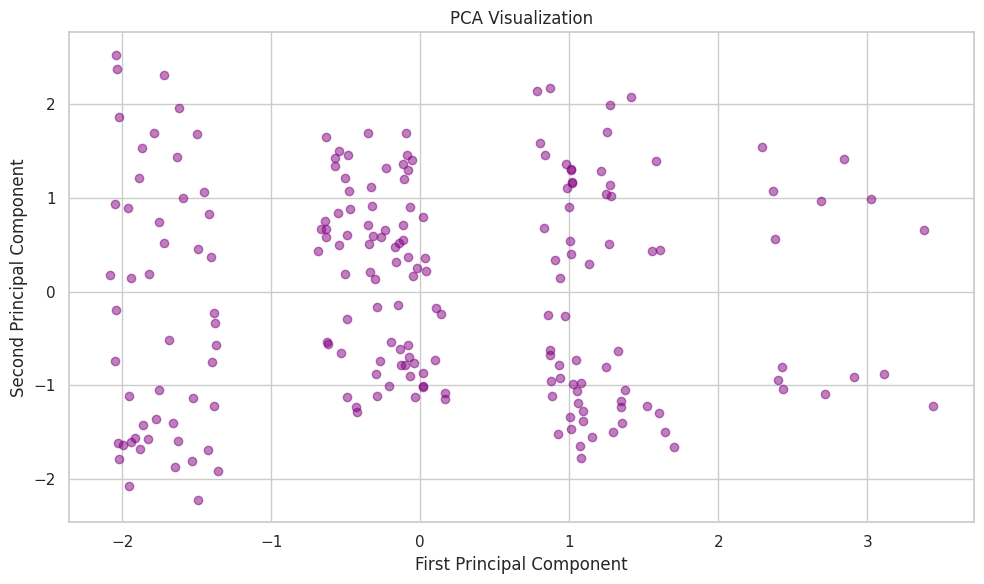

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, c='purple')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Visualization')

plt.tight_layout()
plt.show()

 * The x-axis represents the First Principal Component. This axis captures the largest amount of variance in the original data.
 * The y-axis represents the Second Principal Component. This axis captures the second largest amount of variance and is perpendicular to the first principal component.

#T_SNE

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)
X_tsne = tsne.fit_transform(X_pca)

Visualize clusters formed after PCA.

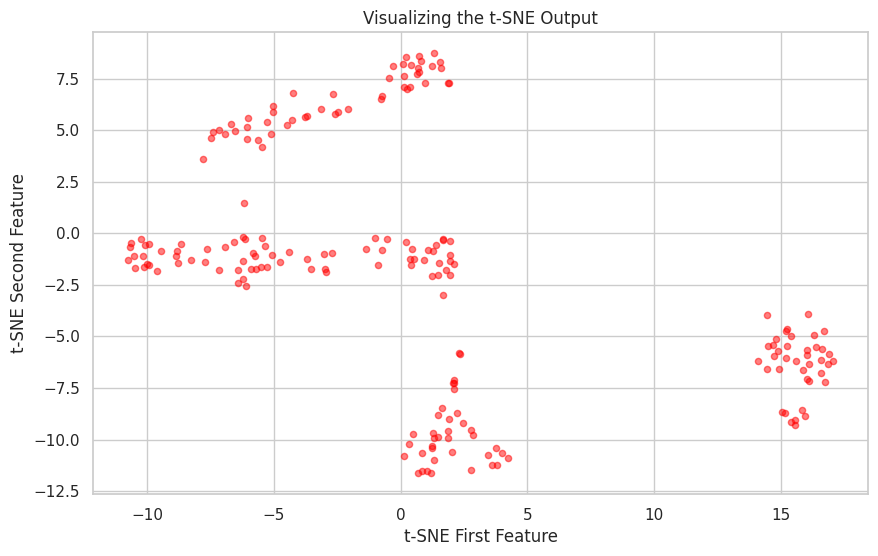

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=20, alpha=0.5, c='red')
plt.title("Visualizing the t-SNE Output")
plt.xlabel("t-SNE First Feature")
plt.ylabel("t-SNE Second Feature")
plt.grid(True)
plt.show()

#Clustering

##KMeans

Applying KMeans clustering to the PCA transformed data to identify natural groupings based on distance.

* Using a for loop to find the 'Inertia' & 'Silhouette' scores at clusters, k = 2-20

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = []
sil_scores = []
Ks = range(2, 21)
for k in Ks:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42, init='random')
    kmeans.fit(X_pca)


    inertias.append(kmeans.inertia_)
    sil = silhouette_score(X_pca, kmeans.labels_, sample_size=10000, random_state=42)
    sil_scores.append(sil)
    print(f"k={k}, inertia={kmeans.inertia_:.2f}, silhouette={sil:.3f}")


k=2, inertia=505.79, silhouette=0.320
k=3, inertia=358.97, silhouette=0.347
k=4, inertia=239.95, silhouette=0.437
k=5, inertia=190.66, silhouette=0.459
k=6, inertia=145.66, silhouette=0.470
k=7, inertia=129.27, silhouette=0.453
k=8, inertia=113.07, silhouette=0.457
k=9, inertia=98.96, silhouette=0.449
k=10, inertia=85.25, silhouette=0.461
k=11, inertia=71.70, silhouette=0.473
k=12, inertia=76.42, silhouette=0.424
k=13, inertia=64.60, silhouette=0.420
k=14, inertia=59.07, silhouette=0.398
k=15, inertia=57.15, silhouette=0.390
k=16, inertia=57.34, silhouette=0.361
k=17, inertia=52.65, silhouette=0.335
k=18, inertia=50.23, silhouette=0.352
k=19, inertia=48.40, silhouette=0.338
k=20, inertia=47.16, silhouette=0.363


Using 'KneeLocator' from kneed to automatically identify the optimal number of clusters to use.

* KneeLocator works by analyzing the curvature of the intertia plot to locate the point of maximum inflection, known as the "Elbow", where the rate of improvement sharply decreases.

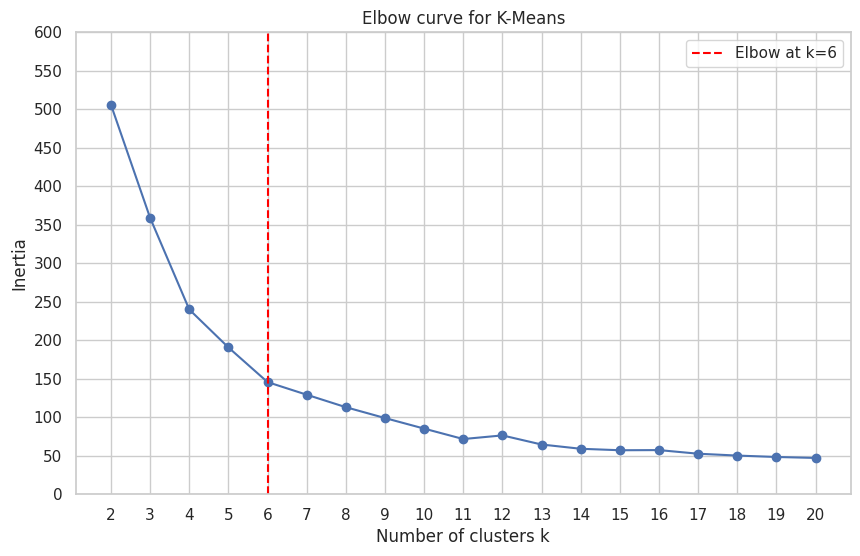

In [26]:
!pip install kneed
from kneed import KneeLocator
kl = KneeLocator(Ks, inertias, curve="convex", direction="decreasing")
elbowK = kl.elbow

plt.figure(figsize=(10, 6))
plt.plot(Ks, inertias, marker='o')
plt.axvline(x=elbowK, color='red', linestyle='--', label=f'Elbow at k={elbowK}')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow curve for K-Means')
plt.xticks(np.arange(2, 21, 1))
plt.yticks(np.arange(0, 601, 50))
plt.legend()
plt.grid(True)
plt.show()

Best compactness at k = 6

Silhouette for K-Means

Visualizing the silhouette scores across different cluster 'K' counts to find the best K that balances compactness, which is always, according to the plot, the highest point or the highest score.

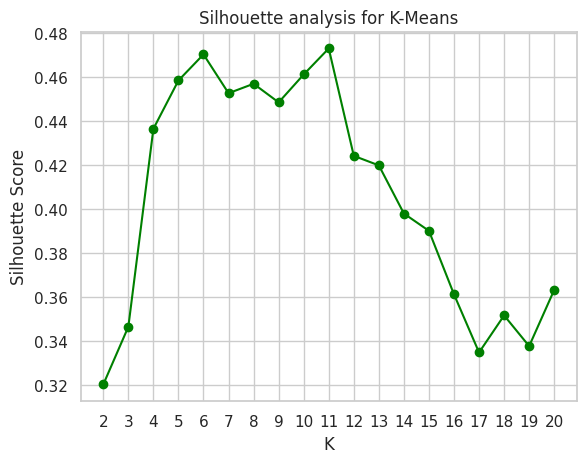

In [27]:
plt.figure()
plt.plot(Ks, sil_scores, marker='o', c='green')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette analysis for K-Means')
plt.xticks(Ks)
plt.show()

According to both the Elbow and Silhouette scores, Best K is 6

5 is a second best using the Silhouette graph.

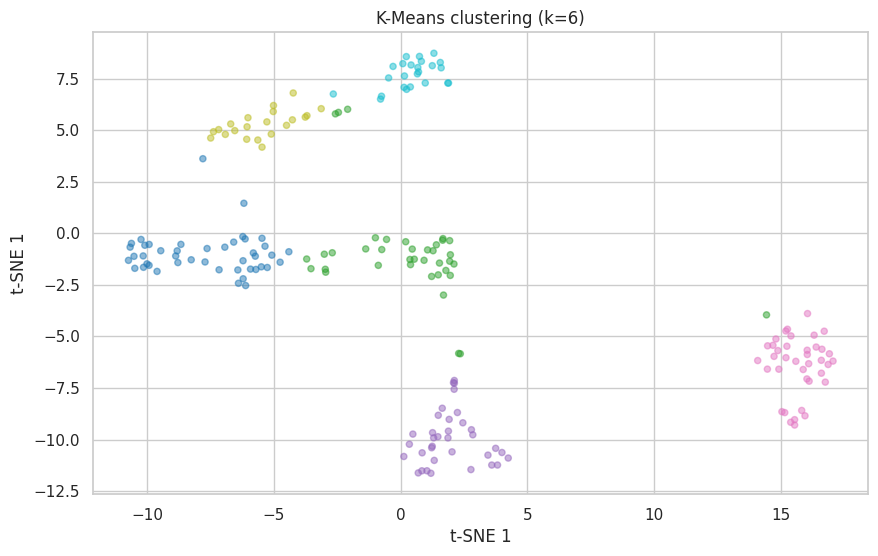

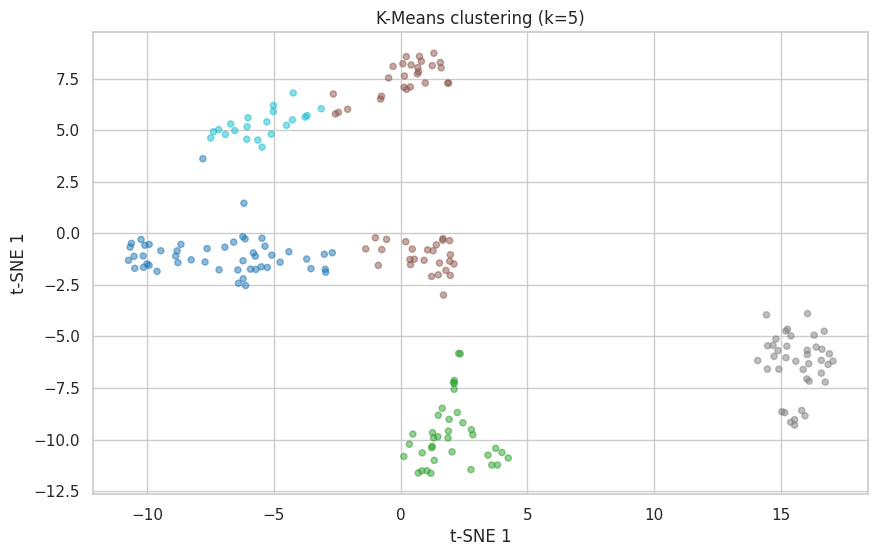

In [28]:
for k in [6, 5]:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    plt.figure(figsize=(10,6))
    plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap='tab10', s=20, alpha=0.5)
    plt.title(f'K-Means clustering (k={k})')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 1')
    plt.grid(True)
    plt.show()


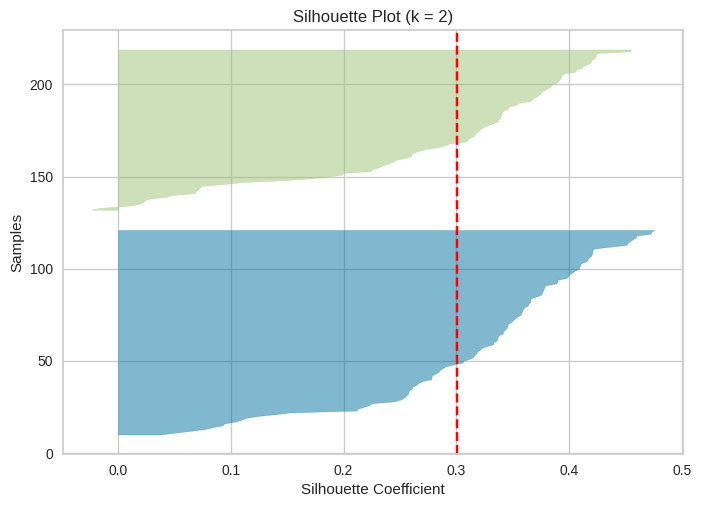

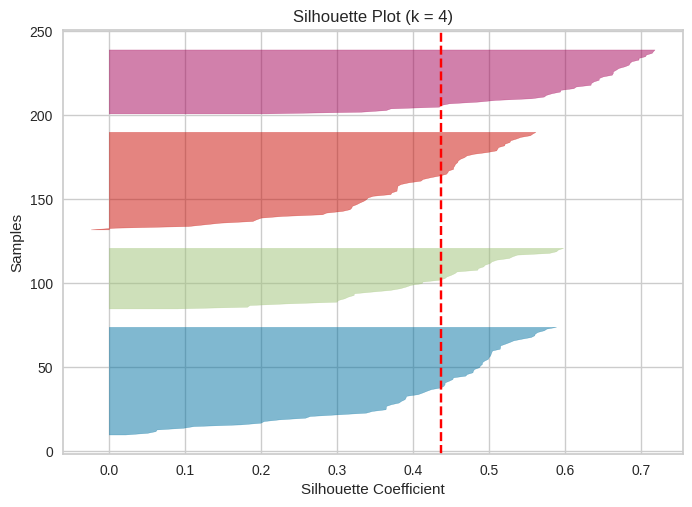

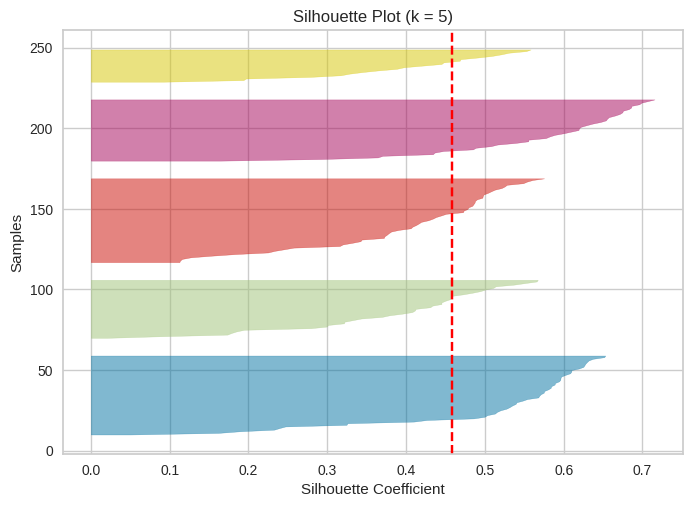

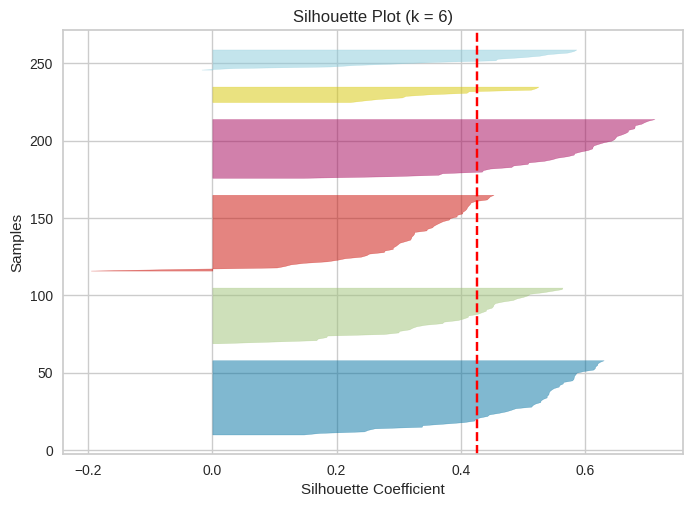

In [29]:
from yellowbrick.cluster import SilhouetteVisualizer
for k in [2,4,5,6]:
   model = KMeans(n_clusters=k,random_state=42)
   visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
   visualizer.fit(X_pca)
   plt.title(f'Silhouette Plot (k = {k})')
   plt.xlabel('Silhouette Coefficient')
   plt.ylabel('Samples')
   plt.show()

## K-Means++

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = []
sil_scores = []
Ks = range(2, 21)
for k in Ks:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_pca)


    inertias.append(kmeans.inertia_)
    sil = silhouette_score(X_pca, kmeans.labels_, sample_size=10000, random_state=42)
    sil_scores.append(sil)
    print(f"k={k}, inertia={kmeans.inertia_:.2f}, silhouette={sil:.3f}")


k=2, inertia=507.88, silhouette=0.303
k=3, inertia=358.35, silhouette=0.347
k=4, inertia=239.95, silhouette=0.437
k=5, inertia=190.66, silhouette=0.459
k=6, inertia=145.66, silhouette=0.470
k=7, inertia=129.20, silhouette=0.454
k=8, inertia=112.85, silhouette=0.459
k=9, inertia=98.29, silhouette=0.470
k=10, inertia=83.90, silhouette=0.476
k=11, inertia=70.44, silhouette=0.480
k=12, inertia=66.14, silhouette=0.467
k=13, inertia=61.80, silhouette=0.447
k=14, inertia=58.44, silhouette=0.434
k=15, inertia=55.31, silhouette=0.394
k=16, inertia=52.27, silhouette=0.396
k=17, inertia=49.12, silhouette=0.392
k=18, inertia=47.41, silhouette=0.370
k=19, inertia=44.27, silhouette=0.393
k=20, inertia=42.69, silhouette=0.371


Elbow for K-Means++

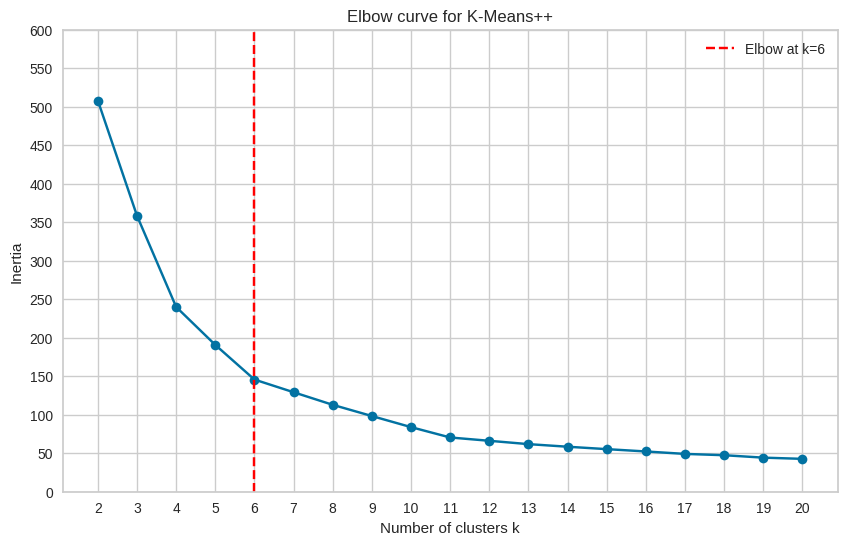

In [31]:
from kneed import KneeLocator
kl = KneeLocator(Ks, inertias, curve="convex", direction="decreasing")
elbowK = kl.elbow

plt.figure(figsize=(10, 6))
plt.plot(Ks, inertias, marker='o')
plt.axvline(x=elbowK, color='red', linestyle='--', label=f'Elbow at k={elbowK}')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow curve for K-Means++')
plt.xticks(np.arange(2, 21, 1))
plt.yticks(np.arange(0, 601, 50))
plt.legend()
plt.grid(True)
plt.show()

Best compactness at k = 6

Silhouette for K-Means++

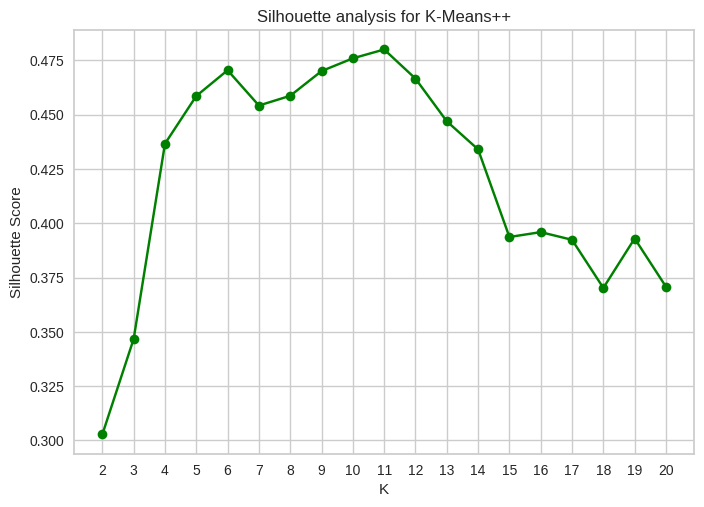

In [32]:
plt.figure()
plt.plot(Ks, sil_scores, marker='o', c='green')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette analysis for K-Means++')
plt.xticks(Ks)
plt.show()


Silhouette score reveals that 11 & 10 are our best options

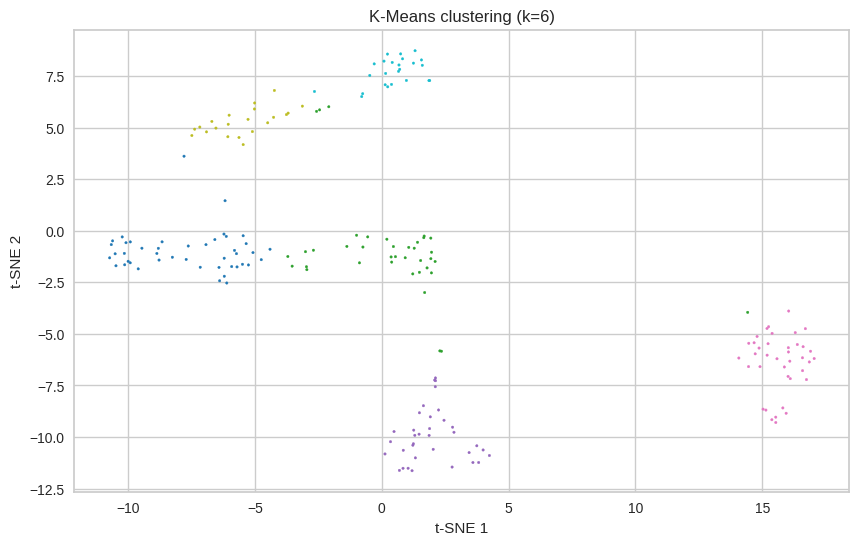

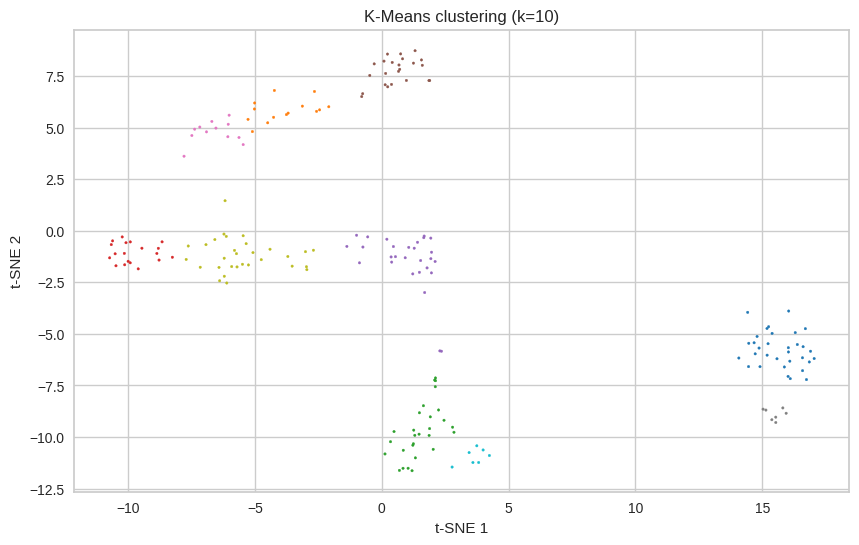

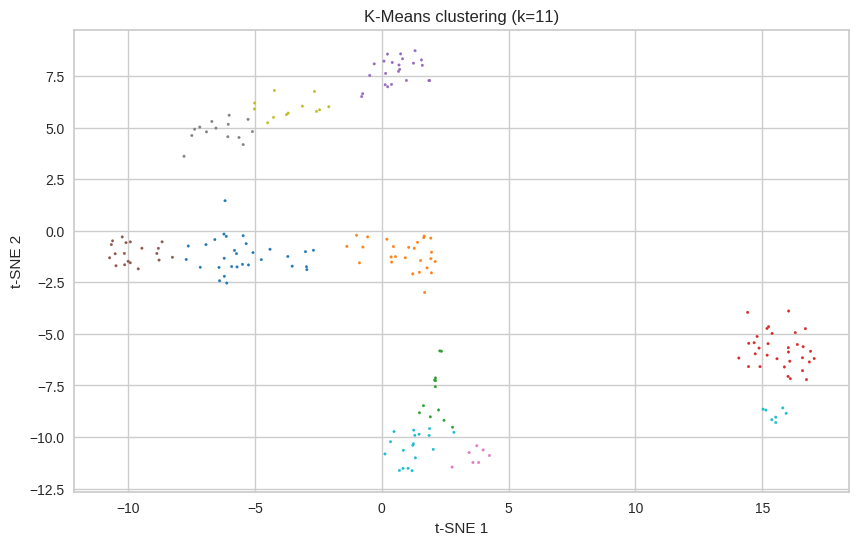

In [33]:
for k in [6, 10, 11]:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    plt.figure(figsize=(10,6))
    plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap='tab10', s=3)
    plt.title(f'K-Means clustering (k={k})')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

***The performance of the two K-Means initialization strategies***

'K-Means' and 'K-Means++'

---
We compare two initialization strategies used in KMeans clustering

The standard random method and the more refined K-Means++. To do this, the function kmeansVSplusplsu(), takes the init method as input, fits a KMeans model with K = 6 on the PCA transformed data, and returns a range of performance metrics. These include:


* Inertia
* Silhouette score
* Calinski-Harabasz score
* Davies-Bouldin score
* Runtime
* Number of iterations until convergence
---



In [34]:
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


k = 6

def kmeansVSplusplus(init_method):
    km = KMeans(n_clusters=k, init=init_method, n_init=10, random_state=42)
    start = time.time()
    km.fit(X_pca)
    runtime = time.time() - start

    labels = km.labels_
    inertia = km.inertia_
    silhouette = silhouette_score(X_pca, labels, random_state=42)
    ch_score = calinski_harabasz_score(X_pca, labels)
    db_score = davies_bouldin_score(X_pca, labels)
    iterations = km.n_iter_

    return {
      'init': init_method,
      'runtime_sec': runtime,
      'inertia': inertia,
      'silhouette': silhouette,
      'calinski_harabasz': ch_score,
      'davies_bouldin': db_score,
      'n_iter': iterations
    }

#KMeans, KMeans++
results_random = kmeansVSplusplus('random')
results_plus   = kmeansVSplusplus('k-means++')

#Printing
for res in (results_random, results_plus):
    print(f"----- KMeans init='{res['init']}' -----")
    print(f"Runtime (s)            : {res['runtime_sec']:.2f}")
    print(f"Inertia                : {res['inertia']:.2f}")
    print(f"Silhouette (sampled)   : {res['silhouette']:.2f}")
    print(f"Calinski–Harabasz      : {res['calinski_harabasz']:.2f}")
    print(f"Davies–Bouldin         : {res['davies_bouldin']:.2f}")
    print(f"Iterations to converge : {res['n_iter']}")

----- KMeans init='random' -----
Runtime (s)            : 0.05
Inertia                : 145.66
Silhouette (sampled)   : 0.47
Calinski–Harabasz      : 160.83
Davies–Bouldin         : 0.73
Iterations to converge : 9
----- KMeans init='k-means++' -----
Runtime (s)            : 0.04
Inertia                : 145.66
Silhouette (sampled)   : 0.47
Calinski–Harabasz      : 160.83
Davies–Bouldin         : 0.73
Iterations to converge : 6


*The results show that both random and k-means++ initializations produced identical clustering performance across all evaluation metrics; however, k-means++ required fewer iterations to converge, making it the more efficient choice for this dataset.*

## Mini-Batch K-Means

Applying Mini-Batch

In [35]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

inertias = []
sil_scores = []
Ks = range(2, 21)
for k in Ks:
    mbkm = MiniBatchKMeans(n_clusters=k, batch_size=1000, n_init=10, random_state=42)
    mbkm.fit(X_pca)


    inertias.append(mbkm.inertia_)
    sil = silhouette_score(X_pca, mbkm.labels_, sample_size=10000, random_state=42)
    sil_scores.append(sil)
    print(f"k={k}, inertia={mbkm.inertia_:.2f}, silhouette={sil:.3f}")


k=2, inertia=514.46, silhouette=0.298
k=3, inertia=363.77, silhouette=0.354
k=4, inertia=240.29, silhouette=0.436
k=5, inertia=193.72, silhouette=0.459
k=6, inertia=146.24, silhouette=0.470
k=7, inertia=132.13, silhouette=0.449
k=8, inertia=127.56, silhouette=0.423
k=9, inertia=98.97, silhouette=0.463
k=10, inertia=96.24, silhouette=0.453
k=11, inertia=82.32, silhouette=0.438
k=12, inertia=66.98, silhouette=0.461
k=13, inertia=73.13, silhouette=0.364
k=14, inertia=64.25, silhouette=0.421
k=15, inertia=61.18, silhouette=0.381
k=16, inertia=52.71, silhouette=0.404
k=17, inertia=54.59, silhouette=0.389
k=18, inertia=50.10, silhouette=0.315
k=19, inertia=45.08, silhouette=0.379
k=20, inertia=44.79, silhouette=0.348


Mini-Batch Elbow

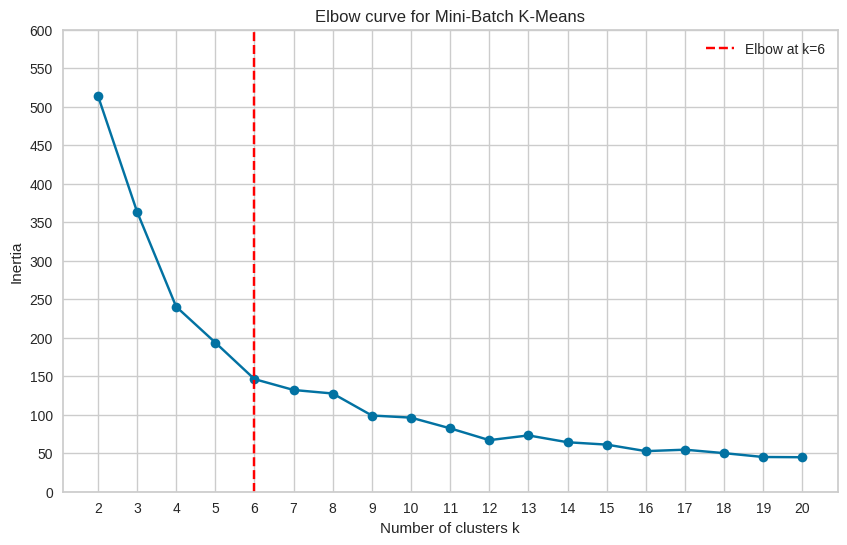

In [36]:
from kneed import KneeLocator
kl = KneeLocator(Ks, inertias, curve="convex", direction="decreasing")
elbowK = kl.elbow

plt.figure(figsize=(10, 6))
plt.plot(Ks, inertias, marker='o')
plt.axvline(x=elbowK, color='red', linestyle='--', label=f'Elbow at k={elbowK}')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow curve for Mini-Batch K-Means')
plt.xticks(np.arange(2, 21, 1))
plt.yticks(np.arange(0, 601, 50))
plt.legend()
plt.grid(True)
plt.show()

Best compactness at k = 6

Silhouette viz for Mini-Batch K-Means

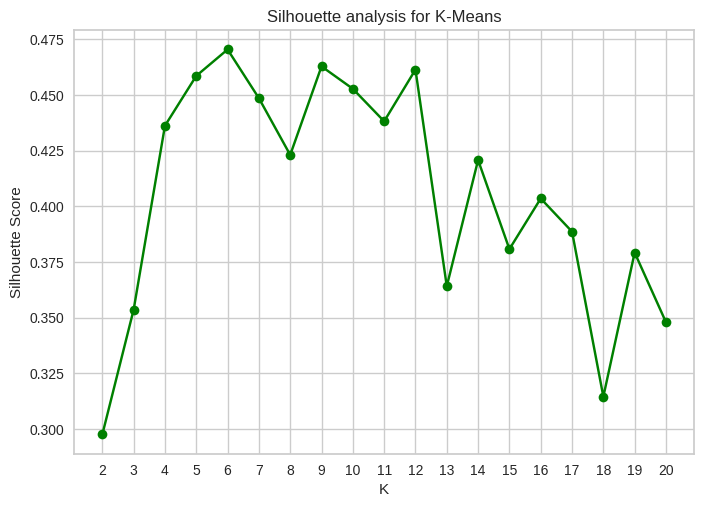

In [37]:
plt.figure()
plt.plot(Ks, sil_scores, marker='o', c='green')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette analysis for K-Means')
plt.xticks(Ks)
plt.show()

The time Mini-Batch is suggesting that we use K = 6 for best separation
K = 9 coming in as second best

Mini-Batch vs Random 'K-Means'
Comparision

In [38]:
import time
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

#K-Means
start = time.time()
km = KMeans(n_clusters=6, init='k-means++', n_init=10, random_state=42)
km.fit(X_pca)
time_km = time.time() - start

labels_km = km.labels_
iters_km = km.n_iter_
inertia_km = km.inertia_
sil_km = silhouette_score(X_pca, labels_km, random_state=42)

print("K-Means:")
print(f"Runtime (s):            {time_km:.2f}")
print(f"Iterations to converge: {iters_km}")
print(f"Inertia:                {inertia_km:.2f}")
print(f"Silhouette:             {sil_km:.3f}\n")

#MiniBatch
start = time.time()
mbkm = MiniBatchKMeans(n_clusters=6, batch_size=1000, n_init=10, random_state=42)
mbkm.fit(X_pca)
time_mb = time.time() - start

labels_mb = mbkm.labels_
iters_mb = mbkm.n_iter_
inertia_mb = mbkm.inertia_
sil_mb= silhouette_score(X_pca, labels_mb, random_state=42)

print("MiniBatchKMeans:")
print(f"Runtime (s):            {time_mb:.2f}")
print(f"Iterations to converge: {iters_mb}")
print(f"Inertia:                {inertia_mb:.2f}")
print(f"Silhouette:             {sil_mb:.3f}")

K-Means:
Runtime (s):            0.02
Iterations to converge: 6
Inertia:                145.66
Silhouette:             0.470

MiniBatchKMeans:
Runtime (s):            0.02
Iterations to converge: 23
Inertia:                146.24
Silhouette:             0.470


While both K-Means and MiniBatchKMeans delivered identical silhouette scores and runtimes, standard K-Means achieved better clustering quality with fewer iterations and lower inertia, making it the preferable option for this dataset.

In [40]:
# grid search for tuning DBSCAN
from sklearn.cluster import DBSCAN
def grid_search_dbscan(X, eps_range, min_samples_range):
    best_score = 0
    for eps in eps_range:
        for min_samples in min_samples_range:
            clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
            labels = clustering.labels_
            if len(set(labels)) > 1 :
                sil_score = silhouette_score(X, labels)
                if sil_score > best_score:
                    best_score = sil_score
                    best_eps = eps
                    best_min_samples = min_samples
                    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return best_score, best_eps, best_min_samples,n_clusters
eps_values = np.arange(0.5,6,0.1)
min_samples_values = np.arange(2,20)
best_score,best_eps,best_min,n_clusters = grid_search_dbscan(X_pca,eps_values,min_samples_values)
print(f"Best Silhouette Score: {best_score}")
print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min}")
print(f"Number of clusters: {n_clusters}")

Best Silhouette Score: 0.32353961851408786
Best eps: 0.7
Best min_samples: 5
Number of clusters: 6


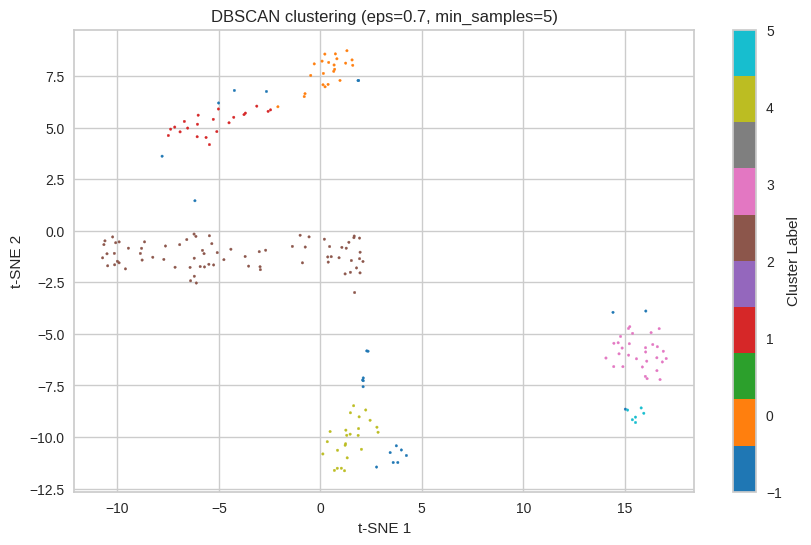

In [41]:
best_eps = round(best_eps,2)
dbscan = DBSCAN(eps=best_eps, min_samples=best_min)
labels = dbscan.fit_predict(X_pca)
plt.figure(figsize=(10,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap='tab10', s=3)
plt.title(f'DBSCAN clustering (eps={best_eps}, min_samples={best_min})')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label="Cluster Label")
plt.grid(True)
plt.show()

In [42]:
# Analyze how noise points are classified.
unique_labels = set(labels)
n_clusters = len(unique_labels)
n_noise = (labels == -1).sum()

print(unique_labels)
print(f"Number of clusters found:   {n_clusters}")
print(f"Number of noise points:     {n_noise}")

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(-1)}
Number of clusters found:   7
Number of noise points:     23


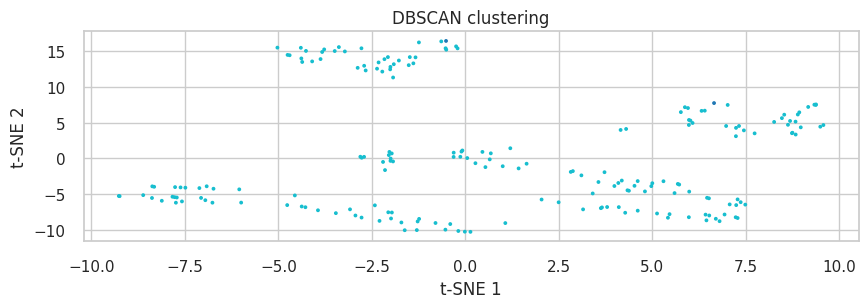

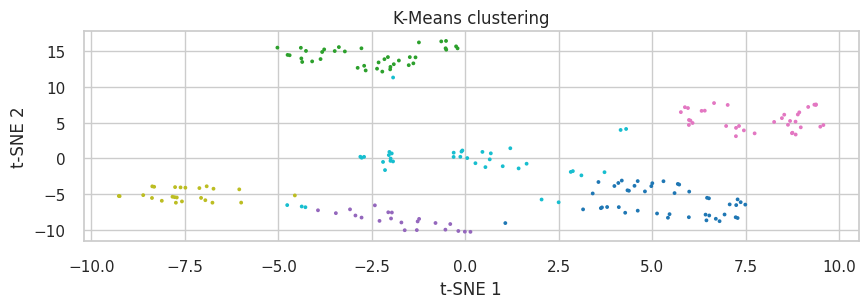

In [ ]:
#Plot clusters and compare to K-Means clusters
kmeans = KMeans(n_clusters=6, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)
# K_means plot
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap='tab10', s=3)
plt.title('DBSCAN clustering')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()
# dbscan plot
plt.figure(figsize=(10,6))
plt.subplot(212)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=kmeans_labels, cmap='tab10', s=3)
plt.title('K-Means clustering')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()